# Visualization of spatial data using KeplerGL

In [ ]:
from keplergl import KeplerGl 
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
import osmnx as ox

def visualize_file(shape, to_crs_value = None):
    
    map = KeplerGl(height=500)
    gpdshape1 = gpd.read_file(shape)
    
    if(to_crs_value != None):
        gpdshape1.crs = "EPSG:4326"
        
    map.add_data(data=gpdshape1, name=shape)
    shape = shape.split('/')[-1]
    file_name = shape.split('.')[-2]
    map.save_to_html(file_name='Visualizations/' + file_name + '.html', read_only=True)    
    
def  visualize_join(shape_1, shape_2):
    
    map_1 = KeplerGl(height=500)
    gpdshape1 = gpd.read_file(shape_1)
    shape_1 = shape_1.split('/')[-1]
    file_1 = shape_1.split('.')[-2]
    gpdshape1.crs = "EPSG:4326"
    
    map_2 = KeplerGl(height=500)
    gpdshape2 = gpd.read_file(shape_2)
    shape_2 = shape_2.split('/')[-1]
    file_2 = shape_2.split('.')[-2]
    
    map_3 = KeplerGl(height=500)
    join_result = gpd.sjoin(gpdshape1, gpdshape2, how="inner", op='contains')
    map_3.add_data(data=join_result, name="join_result")
    map_3.save_to_html(file_name='Visualizations/'+file_1+'_join_'+file_2+'.html', read_only=True)

In [ ]:
visualize_file("Datasets/shape_files/gadm36_IND_0.shp", 4362)

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://geopandas.org/_images/overlay_operations.png")

# Spatial Join on CPU and GPU without indexing and splitting

In [2]:
import time
import geopandas as gpd
from numba.extending import overload
import matplotlib.pyplot as plt

def sjoin_without_indexing(data_1, data_2, device = 'CPU', plot = True):
    start_time = time.time()
    join_result = gpd.sjoin(data_1, data_2, how="inner", op='intersects')
    end_time = time.time()
    print("S-join without splitting on {0} = {1}".format(device, end_time - start_time))
    
    if plot:
        join_result.plot(ec = "#0b1878", figsize=(15,15))

@overload(sjoin_without_indexing)
def gpu_sjoin_without_indexing(data1, data2, plot = True):
    sjoin_without_indexing(data1, data2, device = 'GPU', plot = plot)

S-join without splitting on CPU = 6.10891318321228
S-join without splitting on GPU = 5.866827726364136


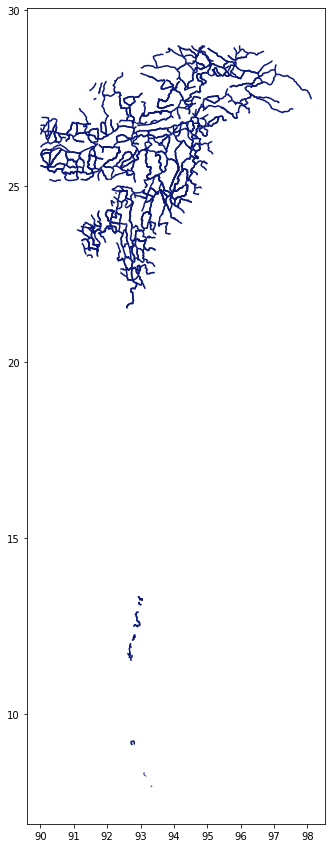

In [3]:
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd

gdb_data = gpd.read_file("Datasets/Geodatabase_format/gROADS-v1-oceania-east.gdb")
data_3 = gpd.read_file("Datasets/shape_files/gadm36_IND_3.shp").set_crs(gdb_data.crs)

sjoin_without_indexing(gdb_data, data_3, plot = False)

gpu_sjoin_without_indexing(gdb_data, data_3, plot = True)

# Spatial Join on CPU and GPU with indexing and without splitting

S-join without splitting on CPU = 5.14151406288147
S-join without splitting on GPU = 0.06008553504943848


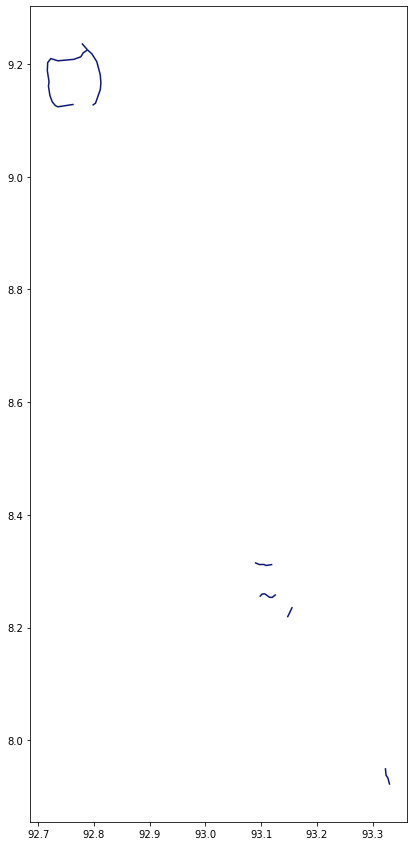

In [5]:
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

from numba.extending import overload

import matplotlib.pyplot as plt
import time

def sjoin_with_indexing(data_1, data_2, device = 'CPU', plot = True):
    
#     convert input data to Multipolygon as needed by sjoin
    geometry_1 = data_1['geometry'].iloc[0]
    if isinstance(geometry_1, Polygon):
        geometry_1 = MultiPolygon([geometry_1])
        
    geometry_2 = data_2['geometry'].iloc[0]
    if isinstance(geometry_2, Polygon):
        geometry_2 = MultiPolygon([geometry_2])
        
    start_time = time.time()
#     indexing data_1
    sindex_1 = data_1.sindex
    sindex_2 = data_2.sindex
    
#     filter phase
    possible_indices = list(sindex_1.intersection(sindex_2.bounds))
    possible_matches = data_1.iloc[possible_indices]
    
#     refinement phase
    precise_matches = possible_matches[possible_matches.intersects(geometry_2)]
    # cannot use index structure of data 2 for intersects operation, accepts Series datatype only     
    end_time = time.time()
    
#     plotting the sjoin results 
    points_within_geometry = precise_matches
    points_outside_geometry = data_1[~data_1.isin(points_within_geometry)]
    
    if plot:
        points_within_geometry.plot(ec = "#0b1878", figsize=(15,15))
    
    print("S-join without splitting on {0} = {1}".format(device, end_time - start_time))
    
@overload(sjoin_with_indexing)
def gpu_sjoin_with_indexing(data_1, data_2, device = 'CPU', plot = True):
    sjoin_with_indexing(data_1, data_2, device = 'GPU', plot = True)
    

gdb_data = gpd.read_file("Datasets/Geodatabase_format/gROADS-v1-oceania-east.gdb")
data_3 = gpd.read_file("Datasets/shape_files/gadm36_IND_3.shp").set_crs(gdb_data.crs)


sjoin_with_indexing(gdb_data, data_3, plot = False)

gpu_sjoin_with_indexing(gdb_data, data_3)

# Output isn't correct

# Convert wkt to GeodataFrames

In [ ]:
from shapely import wkt

wkt_csv_data = pd.read_csv("Datasets/wkt_format/primaryroads_wkt.csv")
wkt_csv_data = wkt_csv_data[].apply(wkt.loads)

wkt_gdf_data = gpd.GeoDataFrame(wkt_csv_data)

wkt_gdf_data.plot(ec = "#0b1878", figsize=(24,24))